In [235]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import plotly.express as px
import plotly.graph_objects as go

In [236]:
tickers = [
    "RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS", "HINDUNILVR.NS",
    "ITC.NS", "KOTAKBANK.NS", "LT.NS", "SBIN.NS", "AXISBANK.NS", "BAJFINANCE.NS",
    "BHARTIARTL.NS", "ASIANPAINT.NS", "HCLTECH.NS", "MARUTI.NS", "SUNPHARMA.NS", "TITAN.NS",
    "ULTRACEMCO.NS", "WIPRO.NS", "TECHM.NS", "NESTLEIND.NS", "POWERGRID.NS", "NTPC.NS",
    "JSWSTEEL.NS", "TATASTEEL.NS", "BAJAJFINSV.NS", "ADANIENT.NS", "ADANIPORTS.NS", "HINDALCO.NS",
    "ONGC.NS", "COALINDIA.NS", "EICHERMOT.NS", "HDFCLIFE.NS", "SBILIFE.NS", "BRITANNIA.NS",
    "DIVISLAB.NS", "CIPLA.NS", "GRASIM.NS", "BPCL.NS", "IOC.NS", "HEROMOTOCO.NS",
    "BAJAJ-AUTO.NS", "SHREECEM.NS", "DRREDDY.NS", "M&M.NS", "INDUSINDBK.NS", "APOLLOHOSP.NS"
]

start_date = '2022-01-01'
end_date = '2024-09-01'

In [237]:
def rmse(true_vol, pred_vol):
  df = pd.concat([true_vol, pred_vol], axis=1).dropna()
  df['sq_error'] = (df.iloc[:,0]-df.iloc[:,1])**2
  return np.sqrt(df['sq_error'].mean())


Calculating three types of volatility forecast and picking best volatility forecasting values(judging from RMSE)

In [238]:
result_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
# Rolling Mean Forecast
    data['returns'] = data['Close'].pct_change()
    data['rolling_vol'] = data['returns'].rolling(window=20).std()

    data['vol_forecast_rm'] = data['rolling_vol'].rolling(window=5).mean()
# Exponentially Weighted Moving Average (EWMA)
    lambda_ = 0.94
    data['vol_squared'] = data['returns']**2
    data['ewma_vol'] = data['vol_squared'].ewm(alpha=1 - lambda_).mean() ** 0.5
# AR(1) model on Volatility
    model = AutoReg(data['rolling_vol'].dropna(), lags=1).fit()

    true_vol = data['rolling_vol'].dropna()
    ar1_pred = model.params['const'] + model.params['rolling_vol.L1'] * true_vol.shift(1)
# judging from RMSE
    rmse_rm = rmse(true_vol, data['vol_forecast_rm'].dropna())
    rmse_ewma = rmse(true_vol, data['ewma_vol'].dropna())
    rmse_ar1 = rmse(true_vol, ar1_pred.dropna())

    best = min((rmse_rm, 'RM'), (rmse_ewma, 'EWMA'), (rmse_ar1, 'AR1'), key=lambda x: x[0])[1]

    if best == 'RM':
        forecast = data['vol_forecast_rm'].iloc[-1]
    elif best == 'EWMA':
        forecast = data['ewma_vol'].iloc[-1]
    else:
            forecast = model.predict(start=len(true_vol), end=len(true_vol)).iloc[0]

    result_df.loc[ticker, 'forecasted_vol'] = forecast

In [239]:
# model.params

Normalizing Forecasted Volatility

In [240]:
result_df['normalized_vol'] = (result_df['forecasted_vol'] - result_df['forecasted_vol'].min()) /(result_df['forecasted_vol'].max() - result_df['forecasted_vol'].min())
# result_df

Calculating the distance & selecting 3 stocks with minimum distance

In [241]:
#investor's risk aversion score
risk_aversion_score = 0.5
result_df['distance'] = abs(result_df['normalized_vol'] - risk_aversion_score)
result_df.sort_values('distance', inplace=True)
# result_df
-
top_stocks = result_df.head(3).copy()
top_stocks

,forecasted_vol,normalized_vol,distance
HDFCLIFE.NS,0.017667,0.490273,0.009727
TECHM.NS,0.018144,0.513945,0.013945
ADANIPORTS.NS,0.018263,0.519834,0.019834


assigning weights inversely proportional to their volatility

In [242]:
initial_investment = 1000000

inv_vol = 1 / top_stocks['forecasted_vol'] # we can also manage portfoilio in bases of distance also
top_stocks['weight'] = inv_vol / inv_vol.sum()

# Final allocation
top_stocks['investment'] = (top_stocks['weight'] * initial_investment).round(2)
top_stocks

,forecasted_vol,normalized_vol,distance,weight,investment
HDFCLIFE.NS,0.017667,0.490273,0.009727,0.340010,340009.68
TECHM.NS,0.018144,0.513945,0.013945,0.331071,331070.72
ADANIPORTS.NS,0.018263,0.519834,0.019834,0.328920,328919.60


In [281]:
hdfc=yf.download("HDFCBANK.NS", start=start_date, end=end_date)
techm=yf.download("TECHM.NS", start=start_date, end=end_date)
adani=yf.download("ADANIPORTS.NS", start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Generating Signals through ATR and plotting their graph with ATR applied

In [282]:
import plotly.graph_objects as go
def atr(df):
    df.columns = df.columns.get_level_values(0)
    high_low = df['High'] - df['Low']
    high_close_prev = abs(df['High'] - df['Close'].shift(1))
    low_close_prev = abs(df['Low'] - df['Close'].shift(1))
    df['ema'] = df['Close'].ewm(span=14, adjust=False).mean()

    df['True_Range'] = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
    df['ATR'] = df['True_Range'].ewm(span=14, adjust=False).mean()

    k = 1.2

    df['up_band'] = df['ema'] + k * df['ATR']
    df['down_band'] = df['ema'] - k * df['ATR']

    df['Signal'] = 0
    df.loc[df['Close'] > df['up_band'], 'Signal'] = 1
    df.loc[df['Close'] < df['down_band'], 'Signal'] = -1

    last_signal = 0
    for i in range(len(df)):
        current = df.loc[df.index[i], 'Signal']
        if current != 0:
            if current == last_signal:
                df.loc[df.index[i], 'Signal'] = 0
            else:
                last_signal = current
    i=0
    while df['Signal'].iloc[i]==0:
      i=i+1
      if df['Signal'].iloc[i] == -1 : df['Signal'].iloc[i] = 0

    buy_df = df[df['Signal'] == 1]
    sell_df = df[df['Signal'] == -1]
    fig=go.Figure()
    fig.add_trace(go.Scatter(x=buy_df.index, y=buy_df['Close'], mode='markers', name='Buy', marker=dict(color='green', symbol='triangle-up', size=12)))
    fig.add_trace(go.Scatter(x=sell_df.index, y=sell_df['Close'], mode='markers', name='Sell', marker=dict(color='red', symbol='triangle-down', size=12)))
    fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name='Close Price', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=df.index, y=df['up_band'], name='UP_band', line=dict(color='orange'),opacity=0.5))
    fig.add_trace(go.Scatter(x=df.index, y=df['down_band'], name='DOWN_band', line=dict(color='black'),opacity=0.5))
    fig.show()
    return df


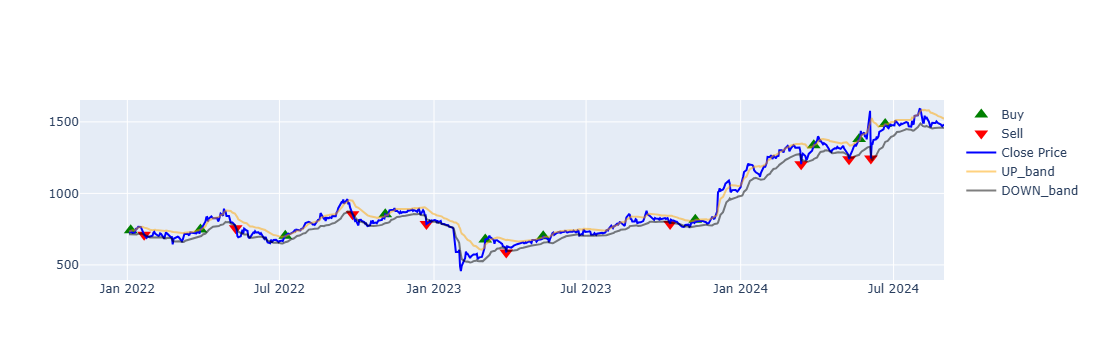

In [283]:
adani_df=atr(adani)
adani_df=adani_df.reset_index()

C:\Users\HP\AppData\Local\Temp\ipykernel_20976\1106393906.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



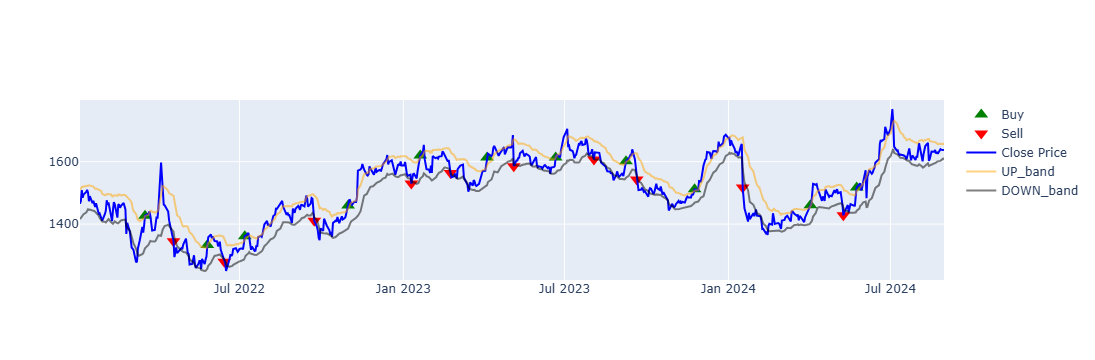

In [284]:
hdfc_df=atr(hdfc)
hdfc_df=hdfc_df.reset_index()

In [285]:
techm_df=atr(techm)
techm_df=techm_df.reset_index()

C:\Users\HP\AppData\Local\Temp\ipykernel_20976\1106393906.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



BACKTESTING

In [286]:
def backtesting(df,signal,initial_capital):
    trade_idx=[]
    opening_trade_idx=[]
    closing_trade_idx=[]
    entry_date=[]
    exit_date=[]
    pos=[]
    type_of_trade=[]

    prev_pos=0
    current_signal=0
    for i in range(len(df)):
        if df.loc[i,signal]==1 or df.loc[i,signal]==-1:
            trade_idx.append(i)
        
        current_signal=df.loc[i,signal]
        
        if current_signal==1:
            if prev_pos==0:
                pos.append(1)
                opening_trade_idx.append(i)
                type_of_trade.append("long")
                entry_date.append(df.loc[i,"Date"])
            elif prev_pos==1:
                pos.append(1)
            elif prev_pos==-1:
                pos.append(0)
                closing_trade_idx.append(i)
                exit_date.append(df.loc[i,"Date"])
        elif current_signal==-1:
            if prev_pos==0:
                pos.append(-1)
                opening_trade_idx.append(i)
                type_of_trade.append("short")
                entry_date.append(df.loc[i,"Date"])
            elif prev_pos==1:
                pos.append(0)
                closing_trade_idx.append(i)
                exit_date.append(df.loc[i,"Date"])
            elif prev_pos==-1:
                pos.append(-1)
        else:
            pos.append(prev_pos)

        prev_pos=pos[i]

    #squaring off all positions at the end
    if pos[len(df)-1]==1:
        pos[len(df)-1]=0
        df.loc[len(df)-1,signal]=-1
        closing_trade_idx.append(len(df)-1)
        exit_date.append(df.loc[len(df)-1,"Date"])
    elif pos[len(df)-1]==-1:
        pos[len(df)-1]=0
        df.loc[len(df)-1,signal]=1
        closing_trade_idx.append(len(df)-1)
        exit_date.append(df.loc[len(df)-1,"Date"])

    
#STOP LOSS FOR LONG TRADES
    for k in range(len(opening_trade_idx)):
        if type_of_trade[k]=="long":
            entry_row=opening_trade_idx[k]
            planned_out=closing_trade_idx[k]
            stop_loss=0.1
            entry_price=df.loc[entry_row,"Close"]
            sl=(1- stop_loss) * entry_price

            for j in range(entry_row,planned_out):
                if df.loc[j,"Close"]< sl:
                    closing_trade_idx[k]=j
                    df.loc[j,signal]=-1
                    df.loc[planned_out,signal]=0
                    break

#DYNAMIC EXIT FOR SHORT TRADES
    for k in range(len(opening_trade_idx)):
        if type_of_trade[k]=="short":
            entry_row=opening_trade_idx[k]
            planned_out=closing_trade_idx[k]
            dynamic_exit=0.1
            entry_price=df.loc[entry_row,"Close"]
            de=(1+ dynamic_exit) * entry_price

            for j in range(entry_row,planned_out):
                if df.loc[j,"Close"]> de:
                    closing_trade_idx[k]=j
                    df.loc[j,signal]=1
                    df.loc[planned_out,signal]=0
                    break


    no_of_shares=[]
    capital=initial_capital
    portfolio=[]
    shares=0
    
    for i in range(len(df)):
        price=df.loc[i,"Close"]
        #long trade
        if df.loc[i,signal]==1 and pos[i-1]==0 and capital>price :
            shares=int(capital/price)
            capital-=shares*price
        elif df.loc[i,signal]==-1 and pos[i-1]==1 and shares>0:
            capital+=shares*price
            shares=0
        #short trade    
        elif df.loc[i,signal]==-1 and pos[i-1]==0 and capital>price:
            shares=-int(capital/price)
            capital-=shares*price
        elif df.loc[i,signal]==1 and pos[i-1]==-1 and shares<0:
            capital+=shares*price
            shares=0
            
        portfolio_value=shares*price+capital
        portfolio.append(portfolio_value)
        no_of_shares.append(shares)
    
    
    returns=[]
    for i in range(len(opening_trade_idx)):
        if type_of_trade[i]=="long":
            returns.append((df.loc[closing_trade_idx[i],"Close"]-df.loc[opening_trade_idx[i],"Close"])*100/df.loc[opening_trade_idx[i],"Close"])
        else:
            returns.append(-(df.loc[closing_trade_idx[i],"Close"]-df.loc[opening_trade_idx[i],"Close"])*100/df.loc[opening_trade_idx[i],"Close"])
        
        
    
    trade_wise_df=pd.DataFrame({"Entry Index": opening_trade_idx,"Exit Index":closing_trade_idx,"Entry Date":entry_date,"Exit Date":exit_date,"Type of Trade":type_of_trade})
    trade_wise_df["No of stock traded"]=[no_of_shares[i]-no_of_shares[i-1] for i in opening_trade_idx]
    trade_wise_df["Return for trade in %"]=returns
    trade_wise_df["Trade Duration"]=trade_wise_df["Exit Index"]-trade_wise_df["Entry Index"]
    #np.where(df_1["Type of trade"]=='long',(returns,-returns)
    
    total_daily=pd.DataFrame({"Portfolio Value":portfolio,"No. of Stock":no_of_shares})
    total_daily["Profit from initial Capital"]=(total_daily["Portfolio Value"]-initial_capital)*100/initial_capital
    total_daily["Daily Returns in %"]=(total_daily["Portfolio Value"].pct_change())*100
    return trade_wise_df,total_daily



In [287]:
adani_trade_wise,adani_daily=backtesting(adani_df,"Signal",top_stocks.loc["ADANIPORTS.NS","investment"])

In [288]:
hdfc_trade_wise,hdfc_daily=backtesting(hdfc_df,"Signal",top_stocks.loc['HDFCLIFE.NS',"investment"])

In [289]:
techm_trade_wise,techm_daily=backtesting(techm_df,"Signal",top_stocks.loc['TECHM.NS',"investment"])

In [290]:
adani_trade_wise

,Entry Index,Exit Index,Entry Date,Exit Date,Type of Trade,No of stock traded,Return for trade in %,Trade Duration
0,2,14,2022-01-05,2022-01-21,long,443,-4.106498,12
1,58,85,2022-03-29,2022-05-10,long,421,0.938373,27
2,128,181,2022-07-08,2022-09-26,long,452,21.472862,53
3,208,242,2022-11-04,2022-12-23,long,452,-7.973125,34
4,291,307,2023-03-03,2023-03-28,long,525,-13.327977,16
5,334,437,2023-05-11,2023-10-09,long,440,12.212361,103
6,458,542,2023-11-08,2024-03-13,long,424,47.740328,84
7,552,578,2024-03-28,2024-05-09,long,382,-7.251180,26
8,585,595,2024-05-21,2024-06-04,long,343,-9.855650,10
9,607,655,2024-06-21,2024-08-30,long,287,-0.242341,48


In [291]:
hdfc_trade_wise

,Entry Index,Exit Index,Entry Date,Exit Date,Type of Trade,No of stock traded,Return for trade in %,Trade Duration
0,51,70,2022-03-17,2022-04-18,long,238,-5.716031,19
1,97,110,2022-05-26,2022-06-14,long,240,-4.002335,13
2,127,180,2022-07-07,2022-09-23,long,226,3.607258,53
3,204,254,2022-10-31,2023-01-10,long,218,4.783859,50
4,262,285,2023-01-20,2023-02-23,long,206,-3.473910,23
5,311,330,2023-04-05,2023-05-05,long,199,-1.699166,19
6,363,393,2023-06-21,2023-08-03,long,196,-0.424917,30
7,418,425,2023-09-08,2023-09-20,long,197,-3.677467,7
8,469,505,2023-11-24,2024-01-17,long,201,0.352459,36
9,554,578,2024-04-02,2024-05-09,long,209,-2.205861,24


In [292]:
techm_trade_wise

,Entry Index,Exit Index,Entry Date,Exit Date,Type of Trade,No of stock traded,Return for trade in %,Trade Duration
0,45,68,2022-03-09,2022-04-12,long,242,-5.964468,23
1,136,175,2022-07-20,2022-09-16,long,327,0.262004,39
2,201,232,2022-10-25,2022-12-09,long,312,-2.697777,31
3,259,317,2023-01-17,2023-04-17,long,309,-1.539126,58
4,341,388,2023-05-22,2023-07-27,long,288,2.198147,47
5,396,431,2023-08-08,2023-09-28,long,263,1.999341,35
6,462,562,2023-11-15,2024-04-15,long,272,3.833860,100
7,570,592,2024-04-26,2024-05-30,long,260,-2.963835,22
8,598,655,2024-06-07,2024-08-30,long,234,20.994377,57


In [293]:
total_daily=adani_daily.loc[:,["Portfolio Value","Profit from initial Capital"]]
total_daily["Portfolio Value"]=total_daily.loc[:,"Portfolio Value"]+hdfc_daily.loc[:,"Portfolio Value"]+techm_daily.loc[:,"Portfolio Value"]
total_daily["Daily Returns in %"]=(total_daily["Portfolio Value"].pct_change())*100
total_daily["Adani Stocks"]=adani_daily.loc[:,"No. of Stock"]
total_daily["HDFC Stocks"]=hdfc_daily.loc[:,"No. of Stock"]
total_daily["Tech Mahindra Stocks"]=techm_daily.loc[:,"No. of Stock"]
total_daily["Profit from initial Capital"]=total_daily.loc[:,"Profit from initial Capital"]+hdfc_daily.loc[:,"Profit from initial Capital"]+techm_daily.loc[:,"Profit from initial Capital"]


In [294]:
total_daily

,Portfolio Value,Profit from initial Capital,Daily Returns in %,Adani Stocks,HDFC Stocks,Tech Mahindra Stocks
0,1.000000e+06,0.000000,NaN,0,0,0
1,1.000000e+06,0.000000,0.000000,0,0,0
2,1.000000e+06,0.000000,0.000000,443,0,0
3,9.934292e+05,-1.997677,-0.657075,443,0,0
4,9.918192e+05,-2.487170,-0.162069,443,0,0
...,...,...,...,...,...,...
651,1.129949e+06,39.583056,0.901158,287,196,234
652,1.124706e+06,38.000471,-0.463997,287,196,234
653,1.122762e+06,37.409608,-0.172799,287,196,234
654,1.129479e+06,39.439551,0.598193,287,196,234


In [298]:
def backtesting_metrics(df1,df2,df3,trade_wise_df1,trade_wise_df2,trade_wise_df3,total_daily):
    initial_value=df1.loc[0,"Close"]+df2.loc[0,"Close"]+df3.loc[0,"Close"]
    final_value=df1.loc[len(df1)-1,"Close"]+df2.loc[len(df2)-1,"Close"]+df3.loc[len(df3)-1,"Close"]
    benchmark_return=((final_value-initial_value)*100)/initial_value
    #benchmark_return=((df.loc[len(df)-1,"Close"]-df.loc[0,"Close"])*100)/df.loc[0,"Close"]
    gross_profit=total_daily.loc[len(total_daily)-1,"Profit from initial Capital"]

    total_trades=len(trade_wise_df1)+len(trade_wise_df2)+len(trade_wise_df3)
    winning_trades= (trade_wise_df1["Return for trade in %"]>0).sum()+(trade_wise_df2["Return for trade in %"]>0).sum()+(trade_wise_df3["Return for trade in %"]>0).sum()
    losing_trades=total_trades-winning_trades
    max_holding_time=max(trade_wise_df1["Trade Duration"].max(),trade_wise_df2["Trade Duration"].max(),trade_wise_df3["Trade Duration"].max())
    avg_holding_time=(trade_wise_df1["Trade Duration"].mean()+trade_wise_df2["Trade Duration"].mean()+trade_wise_df3["Trade Duration"].mean())/3

    #to calculate max drawdown
    total_daily["Cumulative Max"] = total_daily["Portfolio Value"].cummax()
    total_daily["Drawdown"] = (total_daily["Portfolio Value"] - total_daily["Cumulative Max"]) / total_daily["Cumulative Max"]
    max_drawdown = total_daily["Drawdown"].min()

    rfr=0.06
    rfr_daily=0.06/252
    total_daily["Excess Returns"]=total_daily["Daily Returns in %"]-rfr_daily
    sharpe_ratio=(total_daily["Excess Returns"].mean()/total_daily["Daily Returns in %"].std()) * np.sqrt(252)


    print("Benchmark Return: "+str(benchmark_return)+" %")
    print("Gross Profit: "+str(gross_profit)+" %")
    print("Max Holding Time: "+str(max_holding_time))
    print("Average Holding Time: "+str(avg_holding_time))
    print("Total Trades: "+str(total_trades))
    print("Winning Trades: "+str(winning_trades))
    print("Losing Trades: "+str(losing_trades))
    print("Max Drawdown: "+str(100*max_drawdown)+" %")
    print("Sharpe Ratio: "+str(sharpe_ratio))
    


In [299]:
backtesting_metrics(adani_df,hdfc_df,techm_df,adani_trade_wise,hdfc_trade_wise,techm_trade_wise,total_daily)

Benchmark Return: 24.402571818840002 %
Gross Profit: 39.09483602219997 %
Max Holding Time: 103
Average Holding Time: 39.35925925925926
Total Trades: 30
Winning Trades: 13
Losing Trades: 17
Max Drawdown: -18.053750334159737 %
Sharpe Ratio: 0.36303468725542126


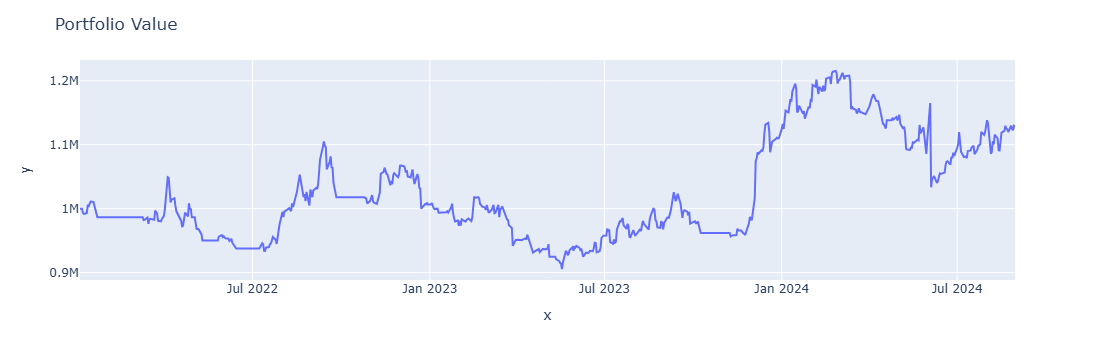

In [300]:
fig=px.line(x=adani_df["Date"],y=total_daily["Portfolio Value"])
fig.update_layout(title="Portfolio Value")
fig.show()